# Analyse de Contrat Perpétuel vs Spot pour Position Longue


Les contrats dérivés occupent une place centrale en finance, permettant aux investisseurs de se couvrir contre les risques ou de spéculer sur les fluctuations futures des prix des actifs sous-jacents. Parmi ces instruments financiers, le contrat perpétuel émerge comme une innovation significative, particulièrement dans le domaine des cryptomonnaies. Contrairement aux contrats à terme traditionnels, qui possèdent une date d'expiration fixe, le contrat perpétuel n'a pas de date d'échéance, ce qui permet aux traders de maintenir une position ouverte indéfiniment. Cette caractéristique unique facilite une correspondance plus étroite entre les prix des contrats perpétuels et ceux du marché au comptant (spot), grâce à l'ajustement périodique des taux de financement. Ces taux visent à équilibrer la différence de prix entre le contrat perpétuel et le marché spot, reflétant ainsi la dynamique de l'offre et de la demande sans nécessiter de règlement physique de l'actif.

L'objectif de ce projet est d'examiner et de comparer les coûts associés à la détention d'une position longue sur un contrat perpétuel par rapport à l'achat direct d'un actif sur le marché spot.

## 1/ Collecte de données





In [ ]:
import requests
from datetime import datetime

# Convertir une date en timestamp (millisecondes)
def date_to_milliseconds(date_str):
    """Convertit une date au format AAAA-MM-JJ en millisecondes depuis l'époque UNIX."""
    epoch = datetime.utcfromtimestamp(0)  # Début de l'époque UNIX
    my_date = datetime.strptime(date_str, "%Y-%m-%d")
    delta = my_date - epoch
    return int(delta.total_seconds() * 1000.0)

start_time = date_to_milliseconds("2023-11-01")
end_time = date_to_milliseconds("2024-03-20")

symbol = 'BTCUSDT'
interval = '1d'  # Interval d'un jour
limit = 1000  # Nombre maximum de points de données par requête

def fetch_klines(url, symbol, interval, start_time, end_time, limit=500):
    data = []

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': limit
    }
    response = requests.get(url, params=params)
    segment = response.json()
    data.extend(segment)
    return data

spot_data = fetch_klines("https://api.binance.com/api/v3/klines", symbol, interval, start_time, end_time, limit)
perp_data = fetch_klines("https://fapi.binance.com/fapi/v1/klines", symbol, interval, start_time, end_time, limit)
funding_rate = fetch_klines("https://fapi.binance.com/fapi/v1/fundingRate", symbol, interval, start_time, end_time, limit)

Dans le cadre de notre projet, nous avons collecté des données historiques sur les prix du Bitcoin (BTC) par rapport à l'USDT (Tether) via l'API de Binance pour la période allant du 1er novembre 2023 au 20 mars 2024.

Une étape clé de notre démarche a été l'utilisation d'une fonction spécifique pour convertir les dates en millisecondes depuis l'époque UNIX, format requis par l'API de Binance pour les requêtes de données.

## 2/ Traitement des données et analyse

In [ ]:
import pandas as pd

# Noms des colonnes pour les DataFrame

columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Volume', 'Taker Buy Quote Volume', 'Ignore']

# Conversion en DataFrame

df_spot = pd.DataFrame(spot_data, columns=columns)
df_perp = pd.DataFrame(perp_data, columns=columns)
df_funding = pd.DataFrame(funding_rate)

# Convertir les timestamps en dates lisibles

df_spot['Open Time'] = pd.to_datetime(df_spot['Open Time'], unit='ms')
df_spot['Close Time'] = pd.to_datetime(df_spot['Close Time'], unit='ms')
df_perp['Open Time'] = pd.to_datetime(df_perp['Open Time'], unit='ms')
df_perp['Close Time'] = pd.to_datetime(df_perp['Close Time'], unit='ms')
df_funding['fundingTime'] = pd.to_datetime(df_funding['fundingTime'], unit='ms')

# S'assurer que les colonnes numériques sont de type correct

columns_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Volume', 'Taker Buy Quote Volume']
df_perp[columns_to_convert] = df_perp[columns_to_convert].apply(pd.to_numeric)
df_spot[columns_to_convert] = df_spot[columns_to_convert].apply(pd.to_numeric)

columns_to_convert = ['fundingRate', 'markPrice']
df_funding[columns_to_convert] = df_funding[columns_to_convert].apply(pd.to_numeric)


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Calculer les rendements quotidiens pour le spot et le perpétuel
df_spot['Daily Return'] = df_spot['Close'].pct_change()
df_perp['Daily Return'] = df_perp['Close'].pct_change()

# Statistiques descriptives des rendements
print("Statistiques descriptives pour le marché Spot:")
print(df_spot['Daily Return'].describe())
print("\nStatistiques descriptives pour le marché Perpétuel:")
print(df_perp['Daily Return'].describe())

# Volatilité (écart-type des rendements quotidiens)
volatility_spot = df_spot['Daily Return'].std()
volatility_perp = df_perp['Daily Return'].std()
print(f"\nVolatilité Spot: {volatility_spot}, Volatilité Perpétuelle: {volatility_perp}")

# Corrélation entre les prix de clôture spot et perpétuels
correlation = df_spot['Close'].corr(df_perp['Close'])
print(f"\nCorrélation entre les prix de clôture Spot et Perpétuel: {correlation}")


# Plot des prix de clôture Spot et Perpétuel

# Création du graphique
fig = go.Figure()

# Ajout de la trace pour les données Spot
fig.add_trace(go.Scatter(x=df_spot['Close Time'], y=df_spot['Close'],
                         mode='lines', name='Spot Close Price'))

# Ajout de la trace pour les données Perpétuelles
fig.add_trace(go.Scatter(x=df_perp['Close Time'], y=df_perp['Close'],
                         mode='lines', name='Perpetual Close Price',
                         line=dict(dash='dash')))

# Mise à jour du layout pour ajouter des titres et activer le zoom
fig.update_layout(title='Comparaison des Prix de Clôture Spot vs Perpétuel',
                  xaxis_title='Date',
                  yaxis_title='Prix de Clôture',
                  dragmode='zoom',  # Activer le zoom
                  hovermode='x unified')  # Afficher les informations au survol

fig.show()

Statistiques descriptives pour le marché Spot:
count    140.000000
mean       0.005057
std        0.028624
min       -0.083902
25%       -0.008393
50%        0.002746
75%        0.018297
max        0.095308
Name: Daily Return, dtype: float64

Statistiques descriptives pour le marché Perpétuel:
count    140.000000
mean       0.005060
std        0.028698
min       -0.084036
25%       -0.008386
50%        0.002589
75%        0.018437
max        0.095238
Name: Daily Return, dtype: float64

Volatilité Spot: 0.028623616718045704, Volatilité Perpétuelle: 0.028697684655388214

Corrélation entre les prix de clôture Spot et Perpétuel: 0.9999986054515368


Ces résultats indiquent une intégration et une efficacité élevées des marchés spot et perpétuel de Bitcoin sur Binance, avec des opportunités de gains similaires et un niveau de risque presque identique. La forte corrélation entre les deux marchés suggère également que les informations sont rapidement intégrées dans les prix sur les deux marchés, reflétant efficacement les nouvelles et les changements de sentiment du marché.

Il est important de noter que ces analyses n'ont pas encore pris en compte l'impact des coûts de financement sur les rendements des contrats perpétuels. Dans les étapes ultérieures, intégrer ces coûts sera crucial pour évaluer la rentabilité nette des positions perpétuelles par rapport aux positions spot.

## 3/ Comparaison d'une postition longue Spot/Perpétuel

In [ ]:
def calculate_funding_costs(filtered_funding, investment_amount, perp_open_price, leverage=4):
    """
    Calcul des coûts de financement pour la position perpétuelle.

    :param filtered_funding: DataFrame des taux de financement filtré pour la période.
    :param investment_amount: Montant investi dans la position.
    :param perp_open_price: Prix d'ouverture de la position perpétuelle.
    :param leverage: Effet de levier utilisé (défaut à 4 pour une marge de 25%).
    :return: Total des coûts de financement.
    """
    # Calculer la taille de la position à l'ouverture avec l'effet de levier
    position_size = (investment_amount / perp_open_price) * leverage

    # Calculer la valeur nominale des positions à chaque intervalle de financement
    filtered_funding['Nominal Value'] = filtered_funding['markPrice'] * position_size

    # Calculer le montant du financement pour chaque intervalle
    filtered_funding['Funding Amount'] = filtered_funding['Nominal Value'] * filtered_funding['fundingRate']

    # Somme des coûts de financement pour la période
    total_funding_cost = filtered_funding['Funding Amount'].sum()

    return total_funding_cost

In [ ]:
def calculate_funding_costs(filtered_funding, investment_amount, perp_open_price, leverage=4):
    """
    Calcul des coûts de financement pour la position perpétuelle.

    :param filtered_funding: DataFrame des taux de financement filtré pour la période.
    :param investment_amount: Montant investi dans la position.
    :param perp_open_price: Prix d'ouverture de la position perpétuelle.
    :param leverage: Effet de levier utilisé (défaut à 4 pour une marge de 25%).
    :return: Total des coûts de financement.
    """
    # Calculer la taille de la position à l'ouverture avec l'effet de levier
    position_size = (investment_amount / perp_open_price) * leverage

    # Calculer la valeur nominale des positions à chaque intervalle de financement
    filtered_funding['Nominal Value'] = filtered_funding['markPrice'] * position_size

    # Calculer le montant du financement pour chaque intervalle
    filtered_funding['Funding Amount'] = filtered_funding['Nominal Value'] * filtered_funding['fundingRate']

    # Somme des coûts de financement pour la période
    total_funding_cost = filtered_funding['Funding Amount'].sum()

    return total_funding_cost


def calculate_profit_loss_with_open_price(investment_amount, start_date, end_date, leverage=4):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filtres pour les périodes spécifiées
    filtered_spot = df_spot[(df_spot['Open Time'] >= start_date) & (df_spot['Close Time'] <= end_date)]
    filtered_perp = df_perp[(df_perp['Open Time'] >= start_date) & (df_perp['Close Time'] <= end_date)]
    filtered_funding = df_funding[(df_funding['fundingTime'] >= start_date) & (df_funding['fundingTime'] <= end_date)].copy()

    # Calculs pour la position spot
    spot_open_price = filtered_spot['Open'].iloc[0]
    spot_close_price = filtered_spot['Close'].iloc[-1]
    spot_profit_loss = ((spot_close_price - spot_open_price) / spot_open_price) * investment_amount

    # Calculs pour la position perpétuelle sans coûts de financement
    perp_open_price = filtered_perp['Open'].iloc[0]
    perp_close_price = filtered_perp['Close'].iloc[-1]
    perp_profit_loss_without_funding = ((perp_close_price - perp_open_price) / perp_open_price) * investment_amount * leverage  # Levier 4x

    # Calcul des coûts de financement
    total_funding_cost = calculate_funding_costs(filtered_funding, investment_amount, perp_open_price, leverage)

    # Ajustement du profit/perte pour les coûts de financement
    perp_profit_loss = perp_profit_loss_without_funding - total_funding_cost

    return {
        "Profit/Perte Spot": spot_profit_loss,
        "Profit/Perte Perpétuel Sans Financement": perp_profit_loss_without_funding,
        "Profit/Perte Perpétuel Avec Financement": perp_profit_loss
    }

# Exemple d'utilisation
investment_amount = 1000  # Montant à investir
start_date = "2024-01-01"
end_date = "2024-03-20"

results = calculate_profit_loss_with_open_price(investment_amount, start_date, end_date)
print(results)

{'Profit/Perte Spot': 464.80974411343595, 'Profit/Perte Perpétuel Sans Financement': 1858.4960060500068, 'Profit/Perte Perpétuel Avec Financement': 1598.009218514448}


Les fonctions `calculate_funding_costs` et `calculate_profit_loss_with_open_price` évaluent les performances d'une position longue sur les marchés spot et perpétuel de Bitcoin contre USDT, en prenant en compte l'impact des coûts de financement sur les positions perpétuelles.

### Fonction `calculate_funding_costs`

Cette fonction calcule le total des coûts de financement pour une position perpétuelle sur une période donnée. Elle prend en compte le montant investi, le prix d'ouverture de la position, l'effet de levier utilisé (avec une marge par défaut de 25% correspondant à un levier de 4), et les données de taux de financement filtrées pour la période d'analyse. La fonction détermine la taille de la position à l'ouverture, calcule la valeur nominale à chaque intervalle de financement, et en déduit le montant du financement pour chaque intervalle. La somme de ces montants représente le coût total de financement pour la position.

### Fonction `calculate_profit_loss_with_open_price`

Cette fonction évalue les profits ou pertes générés par les positions spot et perpétuelles sur une période spécifique. Elle filtre les données de marché spot, perpétuel, et de financement pour la période choisie, calcule le profit ou la perte pour la position spot basé sur les prix d'ouverture et de clôture, et réalise un calcul similaire pour la position perpétuelle, mais ajuste ce dernier pour inclure l'effet de l'effet de levier et les coûts de financement calculés par la fonction précédente. Enfin, la fonction retourne les résultats sous forme d'un dictionnaire, offrant une comparaison directe des performances financières des deux types de positions, avec et sans l'ajustement pour les coûts de financement.

### Application Pratique

L'exemple d'utilisation fourni démontre comment ces fonctions peuvent être appliquées pour analyser les performances d'un investissement de 1000 $ sur la periode étudiée. Les résultats imprimés donnent une vision claire de l'impact financier des coûts de financement sur les positions perpétuelles par rapport aux positions spot.

---

La formule utilisée pour calculer le coût de financement dans une position perpétuelle, telle qu'implémentée dans la fonction `calculate_funding_costs`, se décompose en plusieurs étapes clés qui reflètent les mécanismes de financement dans les marchés de contrats à terme perpétuels sur les cryptomonnaies. Voici les formules principales :

### 1. Taille de la Position à l'Ouverture
$$
\text{Taille de la Position} = \left( \frac{\text{Montant Investi}}{\text{Prix d'Ouverture Perpétuel}} \right) \times \text{Levier}
$$

Cette formule calcule la taille de la position en unités de l'actif sous-jacent, en prenant en compte l'effet de levier. Le montant investi est divisé par le prix d'ouverture de la position perpétuelle, puis multiplié par le levier pour ajuster la taille de la position selon la marge utilisée.

### 2. Valeur Nominale des Positions
$$
\text{Valeur Nominale} = \text{Mark Price} \times \text{Taille de la Position}
$$

À chaque intervalle de financement, la valeur nominale de la position est recalculée en multipliant le mark price (prix de repère) par la taille actuelle de la position. Cela reflète la valeur totale de la position à ce moment précis.

### 3. Montant du Financement pour Chaque Intervalle
$$
\text{Montant du Financement} = \text{Valeur Nominale} \times \text{Taux de Financement}
$$

Le montant du financement pour chaque intervalle est déterminé en multipliant la valeur nominale de la position par le taux de financement applicable. Ce taux peut être positif (les détenteurs de positions longues paient les détenteurs de positions courtes) ou négatif (les détenteurs de positions courtes paient les détenteurs de positions longues), selon la dynamique du marché.

### 4. Total des Coûts de Financement pour la Période
$$
\text{Total des Coûts de Financement} = \sum \text{Montants du Financement pour chaque intervalle}
$$

Le coût total de financement sur la période analysée est la somme de tous les montants de financement calculés pour chaque intervalle de financement pendant la durée de la position.

Ces formules ensemble permettent d'évaluer l'impact financier des taux de financement sur une position perpétuelle dans le marché des cryptomonnaies, offrant ainsi une vue complète des coûts associés à la détention d'une telle position sur la durée spécifiée.

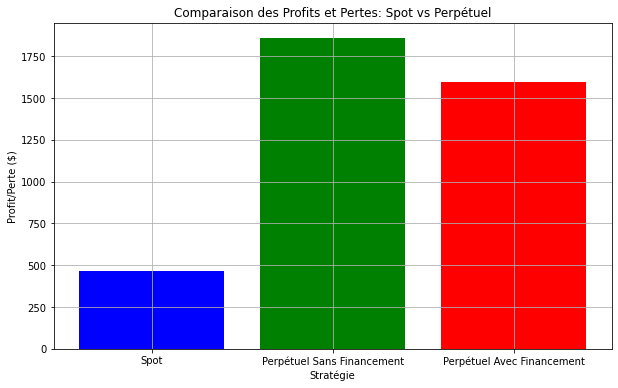

In [ ]:
import matplotlib.pyplot as plt

# Noms des stratégies
strategies = ['Spot', 'Perpétuel Sans Financement', 'Perpétuel Avec Financement']

# Profits et pertes pour chaque stratégie
profits_losses = [results["Profit/Perte Spot"], results["Profit/Perte Perpétuel Sans Financement"], results["Profit/Perte Perpétuel Avec Financement"]]

# Création d'un barplot
plt.figure(figsize=(10, 6))
plt.bar(strategies, profits_losses, color=['blue', 'green', 'red'])
plt.xlabel('Stratégie')
plt.ylabel('Profit/Perte ($)')
plt.title('Comparaison des Profits et Pertes: Spot vs Perpétuel')
plt.grid(True)
plt.show()

### Interprétation

1. **Performance Relative** :
   - La position sur le marché spot a généré un profit de 464.81 \$, ce qui est un bon retour sur investissement pour un marché traditionnellement moins volatil que les options ou les contrats perpétuels.
   - Sur le marché perpétuel, avant de prendre en compte les coûts de financement, le profit était significativement plus élevé, atteignant 1858.50 \$. Cela illustre le potentiel de rendement plus élevé que peuvent offrir les marchés perpétuels, en particulier lorsque l'effet de levier est utilisé (ici un levier de 4).

2. **Impact des Coûts de Financement** :
   - Après ajustement pour les coûts de financement, le profit sur le marché perpétuel diminue à 1598.01 \$. Cela montre l'effet notable que les frais de financement peuvent avoir sur la rentabilité nette des positions perpétuelles. Les coûts de financement réduisent le profit initial de 260.49 \$.
   - L'ajustement des profits pour les coûts de financement est crucial pour évaluer la rentabilité réelle des stratégies de trading sur les marchés de dérivés, car ces coûts peuvent parfois être significatifs.

3. **Volatilité et Risque** :
   - La plus grande différence entre les profits des marchés spot et perpétuel (même après ajustement pour les coûts de financement) souligne la volatilité accrue et le risque associé aux positions perpétuelles. Toutefois, cela vient avec le potentiel de rendements accrus, comme démontré par les résultats avant et après les frais de financement.


## Conclusion

Les résultats obtenus démontrent clairement l'importance de considérer tous les aspects des positions de trading, y compris les coûts indirects comme les frais de financement, surtout lorsqu'on utilise des stratégies impliquant un effet de levier.

**Limitations et Risques Supplémentaires :**

Cependant, notre analyse présente des limitations importantes qui doivent être soulignées pour une interprétation correcte des résultats, notamment en ce qui concerne l'absence de considération pour l'appel de marge et le risque de faillite :

1. **Absence de l'Appel de Marge :**
   - Dans notre modèle actuel, nous n'avons pas intégré les mécanismes d'appel de marge, qui sont cruciaux dans la gestion des positions à effet de levier. L'appel de marge survient lorsque la valeur des fonds détenus en garantie tombe en dessous d'un certain seuil requis, obligeant l'investisseur à ajouter des fonds supplémentaires pour maintenir sa position ouverte. Cette dynamique peut avoir un impact significatif sur la liquidité de l'investisseur et sur sa capacité à maintenir des positions ouvertes en période de volatilité accrue.
   
2. **Risque de Faillite :**
   - L'utilisation d'un levier élevé, comme observé dans les contrats perpétuels, augmente également le risque de faillite, surtout si la valeur du contrat baisse de manière significative. Si les pertes excèdent les marges déposées, l'investisseur peut non seulement perdre la totalité de son investissement initial mais également être tenu responsable de toute dette restante si les actifs détenus en garantie ne suffisent pas à couvrir les pertes.

En conclusion, bien que les contrats perpétuels puissent offrir des rendements élevés, ils viennent avec un niveau de risque correspondant qui nécessite une attention méticuleuse et une gestion stratégique des positions pour éviter des pertes catastrophiques. Les investisseurs doivent évaluer leur tolérance au risque et leur capacité à gérer les appels de marge avant d'engager des capitaux significatifs dans ces instruments financiers.

Pour finir nous presentons une application web interactive avec Jupyter Dash pour visualiser les données des marchés spot et perpétuel de crypto-monnaies. L'application nous permet de sélectionner des plages de dates via un sélecteur de dates et affiche des graphiques de séries temporelles pour les prix d'ouverture des deux marchés. En fonction des dates sélectionnées, elle calcule et affiche les profits ou pertes pour les positions spot et perpétuelles, en ajoutant des annotations sur les graphiques pour indiquer ces valeurs.

In [ ]:
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd

# Créer une application Dash
app = JupyterDash(__name__)


# Définir la disposition de l'application
app.layout = html.Div([
    html.H1("Visualisation des Données de Marché Spot et Perpétuel"),
    dcc.DatePickerRange(
        id='date-picker-range',
        start_date=df_spot['Open Time'].min(),
        end_date=df_spot['Open Time'].max(),
        display_format='YYYY-MM-DD'
    ),
    dcc.Graph(id='time-series-chart')
])


@app.callback(
    Output('time-series-chart', 'figure'),
    [Input('date-picker-range', 'start_date'),
     Input('date-picker-range', 'end_date')]
)
def update_graph(start_date, end_date):
    filtered_df_spot = df_spot[(df_spot['Open Time'] >= pd.to_datetime(start_date)) & (df_spot['Open Time'] <= pd.to_datetime(end_date))]
    filtered_df_perp = df_perp[(df_perp['Open Time'] >= pd.to_datetime(start_date)) & (df_perp['Open Time'] <= pd.to_datetime(end_date))]

    # Calcul des profits
    if not filtered_df_spot.empty and not filtered_df_perp.empty:
            profit = calculate_profit_loss_with_open_price(1000, pd.to_datetime(start_date), pd.to_datetime(end_date))
            profit_spot = profit["Profit/Perte Spot"]
            profit_perp = profit["Profit/Perte Perpétuel Avec Financement"]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_df_spot['Open Time'], y=filtered_df_spot['Open'], mode='lines', name='Spot Open Price'))
    fig.add_trace(go.Scatter(x=filtered_df_perp['Open Time'], y=filtered_df_perp['Open'], mode='lines', name='Perpetual Open Price', line=dict(dash='dash')))

    # Annotations pour les profits
    fig.add_annotation(x=filtered_df_spot['Open Time'].max(), y=filtered_df_spot['Open'].max(),
                       text=f"Profit Spot: ${profit_spot:.2f}",
                       showarrow=True, arrowhead=1, ax=-100, ay=-50)
    fig.add_annotation(x=filtered_df_perp['Open Time'].max(), y=filtered_df_perp['Open'].max(),
                       text=f"Profit Perp: ${profit_perp:.2f}",
                       showarrow=True, arrowhead=1, ax=-100, ay=-100)

    fig.update_layout(title='Time Series Data for Spot and Perpetual Markets',
                      xaxis_title='Open Time', yaxis_title='Open Price')

    return fig

# Exécuter l'application dans le notebook
app.run_server(mode='external')

C:\Users\danal\Anaconda3\lib\site-packages\dash\dash.py:550: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Dash app running on http://127.0.0.1:8050/
